In [0]:
#importing all the required packages
import numpy as np
import pandas as pd
import nltk as nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import statistics as s
from sklearn.metrics import confusion_matrix 
from scipy.sparse import hstack

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#importing preprocessed data
df=pd.read_csv('/content/drive/My Drive/AIt/job_data.csv')

In [7]:
df.shape

(17879, 16)

In [0]:
#Dropping the Un-named column
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [0]:
#Preparing the data for train test split
x=df.drop(['fraudulent'],axis=1)
y=df['fraudulent']

In [0]:
#splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [0]:
#reset the custom index generated during train, test split
X_train=X_train.reset_index()
X_test=X_test.reset_index()
y_train=y_train.reset_index()
y_test=y_test.reset_index()

In [0]:
#delete the index generated during train, test split
X_train=X_train.drop(['index'],axis=1)
X_test=X_test.drop(['index'],axis=1)
y_train=y_train.drop(['index'],axis=1)
y_test=y_test.drop(['index'],axis=1)

In [0]:
#copy y_train and y_test into x_gtrain and x_test to do oversampling on train set
X_train['fraudulent']=y_train
X_test['fraudulent']=y_test

In [14]:
X_train.head()


,job_data,telecommuting,has_company_logo,has_questions,Contract,Full-time,Other,Part-time,Temporary,Information Technology,Management,Marketing and Finance,Other.1,Sales,fraudulent
0,execut assist acumen fund we provid recruit se...,0,1,1,0,1,0,0,0,0,1,0,0,0,0
1,senior web ui develop javascript html5 css3 vi...,0,1,1,0,1,0,0,0,1,0,0,0,0,0
2,bill clerk the best word to describ pcp s cult...,0,1,1,0,1,0,0,0,1,0,0,0,0,0
3,custom servic associ novitex enterpris solut f...,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,bankruptci specialist tidewat financ co wa est...,0,1,0,0,1,0,0,0,1,0,0,0,0,0


In [0]:
#separate the non-fraudulent data and fraudulent data to duplicate fraudulent data
nonfraudulent_train=X_train[X_train['fraudulent']==0]
fraudulent_train=X_train[X_train['fraudulent']==1]

In [0]:
#duplicate the fraudulent data by 17 times
#after conducting experiments duplicating it 17 times gives optimal accuracy
fraudulent_train=fraudulent_train.append([fraudulent_train]*17,ignore_index=True)

In [0]:
#join the duplicated fraudulent data to the non fraudulent data
final_train=fraudulent_train.append(nonfraudulent_train,ignore_index=True)
final_test=X_test

In [0]:
#save these train and test sets to use it for CNN model
final_train.to_csv("trainset.csv")
final_test.to_csv("testset.csv")

In [19]:
final_train.head()

,job_data,telecommuting,has_company_logo,has_questions,Contract,Full-time,Other,Part-time,Temporary,Information Technology,Management,Marketing and Finance,Other.1,Sales,fraudulent
0,execut sou chef le meridien is situat in the h...,0,1,0,1,0,0,0,0,1,0,0,0,0,1
1,account manag noinform account managerjoin a g...,0,0,0,0,0,0,1,0,0,0,0,0,1,1
2,we need 25 agent grow compani see below noinfo...,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,cash pay vacanc appli today noinform cash pay ...,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,optician noinform long term establish and resp...,0,0,0,0,1,0,0,0,0,0,0,0,1,1


In [0]:
# copy the data frame into a new variable to use it for horizontal stack
new_df=final_train.copy()
new_df.drop(['job_data','fraudulent'],axis=1,inplace=True)

In [21]:
#We see that train set increased from 17000 to 25000 after oversampling
final_train.shape

(25795, 15)

In [22]:
#The test set remain same as we do not want leakage of data
y_test.shape

(3576, 1)

In [0]:
#arrange the data into final train and test sets
finalx_train=final_train.drop('fraudulent',axis=1)
finaly_train=final_train['fraudulent']
finalx_test= X_test.drop('fraudulent',axis=1)
finaly_test= X_test['fraudulent']


In [24]:
finalx_train.head()

,job_data,telecommuting,has_company_logo,has_questions,Contract,Full-time,Other,Part-time,Temporary,Information Technology,Management,Marketing and Finance,Other.1,Sales
0,execut sou chef le meridien is situat in the h...,0,1,0,1,0,0,0,0,1,0,0,0,0
1,account manag noinform account managerjoin a g...,0,0,0,0,0,0,1,0,0,0,0,0,1
2,we need 25 agent grow compani see below noinfo...,0,0,0,0,1,0,0,0,1,0,0,0,0
3,cash pay vacanc appli today noinform cash pay ...,0,0,0,0,0,0,1,0,0,0,1,0,0
4,optician noinform long term establish and resp...,0,0,0,0,1,0,0,0,0,0,0,0,1


In [25]:
#Doing K fold Cross Validation on the training set. We use 5 folds so n_splits=5
folds = StratifiedKFold(n_splits=5, random_state=0)
i=0
#create a list for storing accuracy reports and scores
acc_report=[]
acc_score=[]
for train, test in folds.split(finalx_train, finaly_train):
    print(train)
    print(test)
    #taking only text data from training data into another variable to perform TF-idf vectorization
    x_train1, x_test1 = finalx_train['job_data'][train], finalx_train['job_data'][test]
    #taking the test data into another variable 
    y_train1, y_test1 = finaly_train[train], finaly_train[test]
    i=i+1
    #Using TF-IDF vectorizer to generate a TF-IDF matrix with ngram range (1,2)
    tfidf = TfidfVectorizer(stop_words="english",ngram_range=(1,2))
    x_train1 = tfidf.fit_transform(x_train1)
    x_test1 = tfidf.transform(x_test1)
    print("tfidf"+str(i))
    
    #Using the copy of the dataframe with no job_data to access the other features of the dataset
    rx_train=new_df.iloc[train]
    rx_test=new_df.iloc[test]

    #Use hstack to horizontally stack the job_data Tf-idf matrix to other features of the dataset
    xtrain_data=hstack( [x_train1,rx_train] )
    xtest_data=hstack( [x_test1,rx_test] )

    #Perform Naive Bayes classification to make predictions on the train data and check how model works on our dataset.
    clf = MultinomialNB(alpha=1.0)
    clf.fit(xtrain_data, y_train1)
    y_pred = clf.predict(xtest_data)
    scores = accuracy_score(y_test1, y_pred)
    report=classification_report(y_test1,y_pred)
    #use append() to store all the 5 reports and scores in the created list
    acc_report.append(report)
    acc_score.append(scores)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[ 2434  2435  2436 ... 25792 25793 25794]
[    0     1     2 ... 14890 14891 14892]
tfidf1
[    0     1     2 ... 25792 25793 25794]
[ 2434  2435  2436 ... 17615 17616 17617]
tfidf2
[    0     1     2 ... 25792 25793 25794]
[ 4868  4869  4870 ... 20340 20341 20342]
tfidf3
[    0     1     2 ... 25792 25793 25794]
[ 7302  7303  7304 ... 23066 23067 23068]
tfidf4
[    0     1     2 ... 23066 23067 23068]
[ 9735  9736  9737 ... 25792 25793 25794]
tfidf5


In [27]:
#mean of validation scores
print(s.mean(acc_score))

0.9913549137429735


In [0]:
#Now using TF-IDF vectorizer to generate TF-IDF matrix for both X_train and x_test with ngram range (1,2)
tfidf = TfidfVectorizer(stop_words="english",ngram_range=(1,2))
x_train=tfidf.fit_transform(finalx_train['job_data'])
x_test=tfidf.transform(finalx_test['job_data'])

In [0]:
#Drop job_data from train and test set for horizontal stacking of job_data's TF-IDF matrix
finalx_train.drop('job_data',axis=1,inplace=True)
finalx_test.drop('job_data',axis=1,inplace=True)

In [0]:
#Use hstack to horizontal stack the TF-IDF matrix to the other features
train_data=hstack( [finalx_train,x_train] )
test_data=hstack( [finalx_test,x_test] )

In [30]:
#check the shape of train data after horizontal stack
train_data.shape

(25795, 773419)

In [31]:
#check the shape of train data before horizontal stack
#The difference of before and after shape is 13 which mean all the other features have been appended correctly
x_train.shape

(25795, 773406)

In [32]:
#using Naive Bayes with smoothing factor value as 1 and make predictionb on test data
clf = MultinomialNB(alpha=1.0)
clf.fit(train_data,finaly_train)
pred = clf.predict(test_data)
scores = accuracy_score(finaly_test, pred)
report=classification_report(finaly_test, pred)
# Print the accuracy report, scores and confusion matrix
print("Accuracy:","\n",scores)
print("Accuracy report:","\n",report)
print("Confusion Matrix:","\n",confusion_matrix(y_test, pred))

Accuracy: 
 0.9812639821029083
Accuracy report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3387
           1       0.80      0.87      0.83       189

    accuracy                           0.98      3576
   macro avg       0.89      0.93      0.91      3576
weighted avg       0.98      0.98      0.98      3576

Confusion Matrix: 
 [[3345   42]
 [  25  164]]


In [33]:
#Using Logistic Regression with default parameters to make predictions on test data
classifier = LogisticRegression()
classifier.fit(train_data , finaly_train)
prediction=classifier.predict(test_data)
model_score = accuracy_score(finaly_test, prediction)
class_report=classification_report(finaly_test, prediction)
# Print the accuracy report, scores and confusion matrix
print("Accuracy:","\n", model_score)
print("Accuracy report:","\n", report)
print("Confusion Matrix:","\n", confusion_matrix(y_test, prediction))

Accuracy: 
 0.9711968680089486
Accuracy report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3387
           1       0.80      0.87      0.83       189

    accuracy                           0.98      3576
   macro avg       0.89      0.93      0.91      3576
weighted avg       0.98      0.98      0.98      3576

Confusion Matrix: 
 [[3313   74]
 [  29  160]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
#packages for ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [0]:
# generate a no skill prediction 
probs = [0 for _ in range(len(finaly_test))]
#predict the probabilities of test data
l_probs = classifier.predict_proba(test_data)
#consider only the fraudulent class
l_probs = l_probs[:,1]
#generate the AUC score for no skill and minority 
auc = roc_auc_score(finaly_test, probs)
l_auc = roc_auc_score(finaly_test, l_probs)

In [0]:
#Generate the ROC curve
falsep, truep, _ = roc_curve(finaly_test, probs)
l_falsep, l_truep, _ = roc_curve(finaly_test, l_probs)

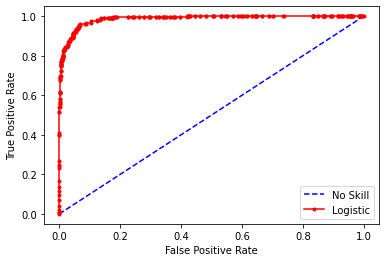

In [47]:
#plot the ROC curve
pyplot.plot(falsep, truep, linestyle='--', label='No Skill',color='blue')
pyplot.plot(l_falsep, l_truep, marker='.', label='Logistic',color='red')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()